In [1]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%cd '/Users/Bisa/Documents/Studium/Masterstudium/5_Semester/MLiM/datasets'

/Users/Bisa/Documents/Studium/Masterstudium/5_Semester/MLiM/datasets


### Train-test-splitting

In [3]:
#train-test-split manually (train: week 50-88; test: 89)
data = pd.read_parquet('/Users/Bisa/Documents/Studium/Masterstudium/5_Semester/MLiM/mlim_13/final_assignment/data_s2000_final.parquet')
#data['product_bought'] = data['product_bought'].astype('float64')

train = data[data['week'] < 80]
test = data[data['week'] >= 80]
print('Observations: %d' % (len(train) + len(test)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

train.to_parquet('train_s2000_w0-79.parquet')
test.to_parquet('test_s2000_w80-90.parquet')

Observations: 3580333
Training Observations: 3182696
Testing Observations: 397637


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182696 entries, 1378724 to 1225694
Data columns (total 32 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   week                            int64  
 1   shopper                         int64  
 2   product                         int64  
 3   price                           float64
 4   discount                        float64
 5   product_bought                  int64  
 6   category_label                  int64  
 7   discount_offered                int64  
 8   purchase_w/o_dis                int64  
 9   no_purchase_w_dis               int64  
 10  discount_effect                 int64  
 11  max_price                       float64
 12  min_price                       float64
 13  no_products_bought              int64  
 14  spend_per_customer              float64
 15  no_unique_products              int64  
 16  discount_purchase               int64  
 17  product_sells        

### LightGBM

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc


#### **What to predict??**

- create col with 1 for discount offered and bought (=1) and discount offered but not used (=2) and others (=0); problem: data is very unbalance

- what will be bought next (with discount)? --> two models? what will be bought next + plus discount would be valuable (heuristic: first x most probable items dont get discount (x = average basket size of shopper), x+1-x+5 get discount 

- max. profit: we want: discount & product

- multiclass problem: 
    - 1 = discount, bought
    - 2 = discount, not bought
    - 3 = no discount, bought
    - 4 = no discount, not bought

#### **What to evaluate?**

- evaluate product bought, yes/no?

- evaluate only redeemed discounts against not redeemed discounts --> too less data?

- evaluate discounts success? --> success = discount was offered and product was bought; unsuccessful = discount was offered but product was not purchase --> also too less data plus data is heavily unbalanced

#### Unbalance

- in lightGBM is a parameter called is_unbalanced --> https://lightgbm.readthedocs.io/en/latest/Parameters.html#is_unbalance
    - works only with binary 
    or 
    -multiclassova (one vs all) --> 1256 (~4.2%) vs 2853~(~96%)

In [5]:
list(train.columns.drop('product_bought'))

['week',
 'shopper',
 'product',
 'price',
 'discount',
 'category_label',
 'discount_offered',
 'purchase_w/o_dis',
 'no_purchase_w_dis',
 'discount_effect',
 'max_price',
 'min_price',
 'no_products_bought',
 'spend_per_customer',
 'no_unique_products',
 'discount_purchase',
 'product_sells',
 'product_dis_sells',
 'product_dis_sells_share',
 'no_products_bought_per_product',
 'customer_prod_dis_purchases',
 'customer_prod_bought_dis_share',
 'customer_prod_dis_offers',
 'customer_prod_dis_offer_share',
 'customer_product_share',
 'customer_mean_product_price',
 'customer_discount_buy_share',
 'week_basket_size',
 'week_basket_value',
 'mean_basket_size',
 'mean_basket_value']

In [8]:
import lightgbm as lgb

#product_bought will be the target variable
X_train, X_test = train.drop('product_bought', axis = 1).values, test.drop('product_bought', axis = 1).values
#y_train, y_test = train.loc[:, train.columns != 'product_bought'].values, test.loc[:, test.columns != 'product_bought'].values

y_train, y_test = train[['product_bought']].values.reshape(-1), test[['product_bought']].values.reshape(-1)

In [ ]:
#feature scaling --> do we need this?
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [9]:
train['product_bought'].value_counts()

0    1957001
1    1225695
Name: product_bought, dtype: int64

In [10]:
d_train = lgb.Dataset(X_train, label = y_train)

In [67]:
#calculate scale_pos_weight
pos = 1225695
neg = 1957001
100 - ((pos / (pos+neg)) * 100)

61.48878183778784

In [82]:
lgb_params = {
    'task': 'train', #or predict
    'objective': 'binary', #for binary classification, could also be 'objective'
    'boosting_type': 'gbdt', #default
    #'num_boost_round': 10, #typically 100+
    'learning_rate': 0.01, #typical values: 0.1, 0.001, 0.003
    'metric': 'binary_logloss',
    'max_depth': 4,
    'num_leaves': 30,
    'verbose': 0,
    'scale_pos_weight': 61.49
    #'categorical_feature': #denotes the index of col that are categorical variables
    }


model = lgb.train(lgb_params, d_train, 30)



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [83]:
#predict
y_pred=model.predict(X_test)

print(y_pred)
print(y_test)

[0.28508246 0.28508246 0.28508246 ... 0.54527577 0.28508246 0.28508246]
[0 0 0 ... 1 0 0]


In [84]:
#set threshold at 0.5 and transform to binary values
y_pred = np.where(y_pred >= 0.5, 1, 0)

In [85]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
#accuracy (auc)
from sklearn.metrics import accuracy_score
auc = accuracy_score(y_pred,y_test)

print(confusion_matrix)
print(auc)

[[244612      0]
 [     0 153025]]
1.0


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def plotImp(model, X, num = 100):
    feature_imp = pd.DataFrame({'value':model.feature_importance(),'features':X.columns.drop('product_bought')})
    plt.figure(figsize = (20, 10))
    sns.set(font_scale = 2)
    sns.barplot(x = 'value', y = 'features', data = feature_imp.sort_values(by = 'value', ascending = False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances.png')
    plt.show()

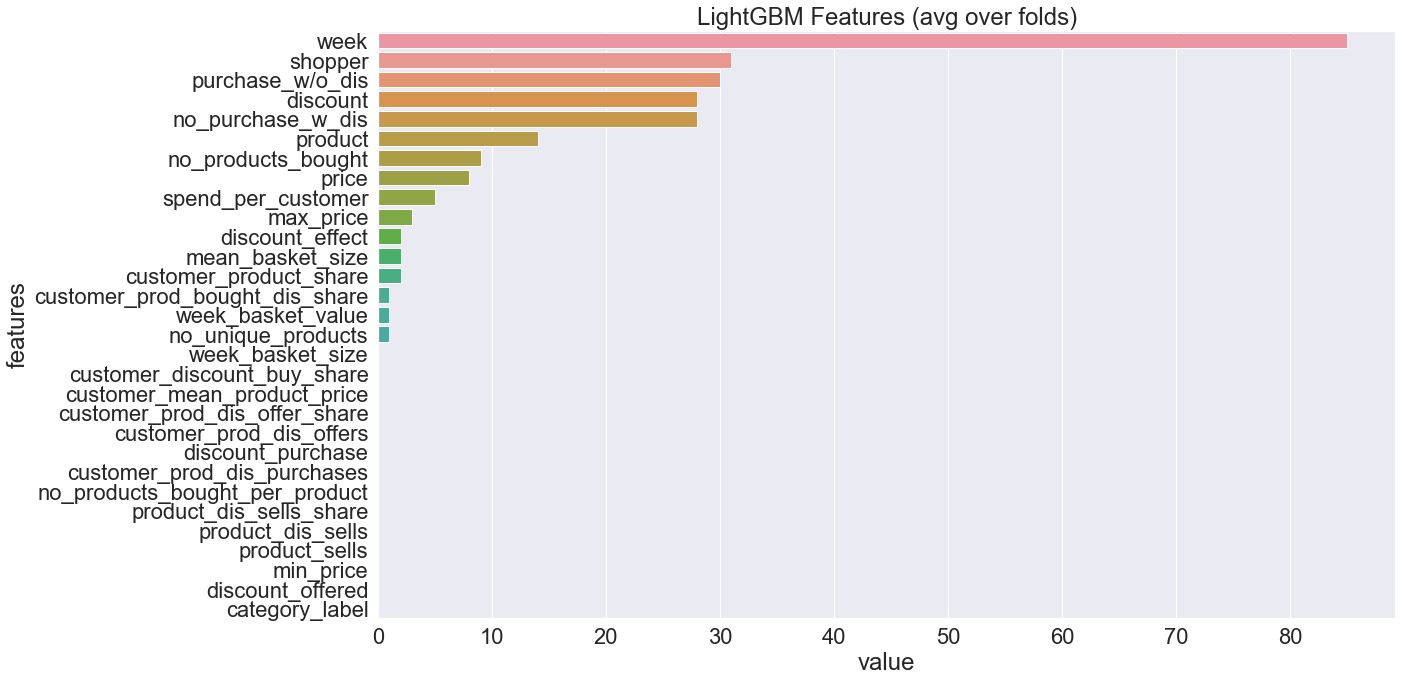

In [88]:
plotImp(model, train, num = 30)

### Analysis

In [ ]:
#only 250 different products
#shorten data frame --> only take the 100 most frequent products
product_count = basket['product'].value_counts().reset_index()
product_count.columns = ['product', 'occurence']
list_most_freq_products = product_count.loc[0:100, 'product']
df_most_freq_products = basket[basket['product'].isin(list_most_freq_products)]
#change of names
baskets = df_most_freq_products.copy()

'TO DO: write a test function for the following part'
#check if everything worked; result of unique product in new data set should be 101 now
print(baskets['product'].nunique())
#show head of new data set
baskets.head()

In [ ]:
#a string input is needed for the word2vec model because it originates in NLP
baskets['product'] = baskets['product'].astype(str)
baskets['week'] = baskets['week'].astype(str)
baskets['shopper'] = baskets['shopper'].astype(str)
#create a basket id to identify each basket --> connecting week and shopper will give an unique each
baskets['basket_id'] = baskets['week'] + '-' + baskets['shopper']

baskets.head()

In [ ]:
params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['sub_feature'] = 0.5
params['num_leaves'] = 64
params['min_data'] = 50
params['max_depth'] = 6
#params['is_unbalance'] = True
params['scale_pos_weight'] = 61.49 #100 - ((pos / (pos+neg)) * 100)
#params['metric'] = 'binary_logloss,auc'
#params['force_col_wise'] = True

basic_model = lgb.train(params, d_train)

In [ ]:
lgb_params = {
    'n_estimators': 5,
    'max_depth':3,
    'random_state': 43
}



clf = lgb.train(lgb_params, d_train)




In [ ]:
train.info()

In [ ]:
lgb_params = {
        'boosting_type': 'gbdt',
        #'objective': objective,
        #'metric':metrics,
        'learning_rate': 0.001,
        'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        #'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 1,
        'metric': 'auc'
    }


clf = lgb.train(lgb_params, d_train, 100)



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

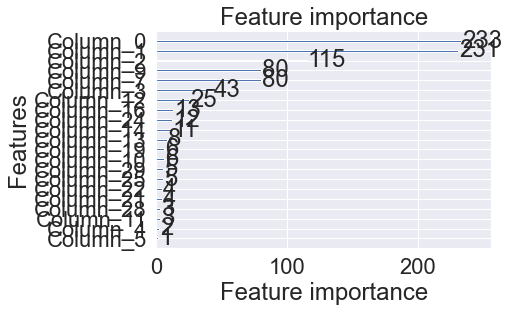

In [58]:
lgb.plot_importance(model)